In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from statannotations.Annotator import Annotator

#import custom modules
import sys
sys.path.insert(0,'/Users/frederickkorbel/Documents/projects/paper/mlcis/utils')

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot,one_hot_encode
import plotseqlogo as sql

sns.set_style('ticks')

In [3]:
from matplotlib.cbook import safe_masked_invalid


def plot_meta(data, model, subset=None):

    if subset is None:
        print(len(data))
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = True)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = True)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)]
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = True)
        
    else:
        raise ValueError()

def plot_attribution(data, model, subset=None, samples=10):

    if subset is None:
        print(len(data))
        data = data.sample(n=samples)
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)].sample(n=samples)
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        sql.seqlogo_fig(np.transpose(lowest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)].sample(n=samples)
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        sql.seqlogo_fig(np.transpose(highest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
        
    else:
        raise ValueError()

def count_gc_perc(seq):

    g_count=seq.count('G')
    c_count=seq.count('C')
    gc_perc=((g_count+c_count)/len(seq))*100

    return gc_perc

def gc(dataframe, seq_column='utr'):

    dataframe['gc_perc']=[count_gc_perc(row) for row in dataframe[seq_column]]
    
    return dataframe

We import datasets for which AUG-bearing reporters were removed and the respective models trained exclusively with nonAUG UTRs to perform attribution on both. 

In [3]:
#import utrs with measured and predicted mean ribosome load

#synthetic utrs with mean ribosome load predicted by MRL model (trained on synthetic utrs without AUG)
no_aug_pred_random=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_aug_random_test_pred.csv', index_col=[0])

#human utrs with mean ribosome load predicted by hMRL model (trained on human utrs without AUG)
no_aug_pred_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_aug_human_test_pred.csv', index_col=[0])

#import the two models trained on human/synthetic utrs without AUG respectively
mrl_model_no_aug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_aug.hdf5')
hmrl_model_no_aug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_aug.hdf5')

2022-11-18 10:03:54.870691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We want to understand how the synthetic and human library differ in sequence composition. Therefore, we compare them in terms of GC-content and number of AUG motifs in the 5'UTR.

/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_6606/3168823742.py:5: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  human_library=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/seelig/Samples/GSM3130443_designed_library.csv', index_col=[0])


synthetic vs. human: t-test independent samples, P_val:0.000e+00 t=-1.958e+02


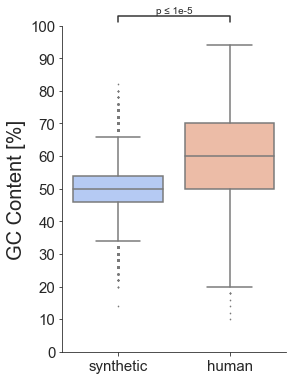

In [32]:
#import the full libraries and count gc content
synthetic_library=gc(pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/seelig/Samples/GSM3130435_egfp_unmod_1.csv', index_col=[0]).sort_values('total', ascending = False).reset_index(drop = True).iloc[:280000])
synthetic_library['dataset']='synthetic'

human_library=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/seelig/Samples/GSM3130443_designed_library.csv', index_col=[0])
human_library = gc(human_library[(human_library['library'] == 'human_utrs') | (human_library['library'] == 'snv')].sort_values('total', ascending = False).reset_index(drop = True).iloc[:25000])
human_library['dataset']='human'

#make a df with gc content per library
gc_df=pd.DataFrame({'synthetic':synthetic_library['gc_perc'], 'human':human_library['gc_perc']})
libraries=pd.concat([synthetic_library, human_library], ignore_index=True)
libraries=libraries[['rl', 'dataset', 'gc_perc']]

#specify which columns to plot
order=['synthetic', 'human']
x='dataset'
y='gc_perc'
pair=[('synthetic', 'human')]

#plot  gc content per library
fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot(data = libraries, x=x, y=y, palette = 'coolwarm', flierprops={'markerfacecolor':'black', 'markersize':0.8}, ax=ax)

annotator=Annotator(ax, pairs=pair, data=libraries, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', show_test_name=False, text_format='simple', loc='outside')
annotator.apply_and_annotate()

plt.setp(ax, ylim=(0,100), yticks = range(0,110,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('GC Content [%]', fontsize=20)

sns.despine()
plt.show()

synthetic vs. human: t-test independent samples, P_val:0.000e+00 t=7.595e+01


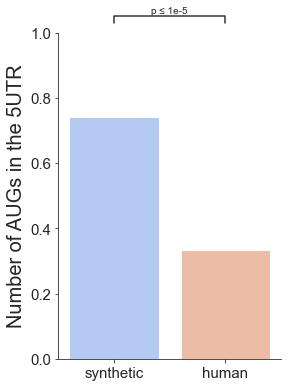

In [52]:
#count the fraction of reporters with AUG motif in their 5'UTR per library
synthetic_library_a=my_utils.analyze(synthetic_library)
human_library_a=my_utils.analyze(human_library)

#calculate fraction of UTRs with one or more AUG motifs
a=len(synthetic_library_a[synthetic_library_a['aug_number']>=1])/len(synthetic_library_a)
b=len(human_library_a[human_library_a['aug_number']>=1])/len(human_library_a)

#make dataframe with data to plot
aug_df=pd.DataFrame({'dataset':['synthetic', 'human'], 'aug_fraction':[a*100,b*100]})
libraries_2=pd.concat([synthetic_library_a, human_library_a], ignore_index=True)
libraries_2=libraries_2[['rl', 'dataset', 'aug_number']]

#specify values to plot
order=['synthetic', 'human']
x='dataset'
y='aug_number'
pair=[('synthetic', 'human')]

#plot data
fig, ax = plt.subplots(figsize=(4,6))
sns.barplot(data=libraries_2, x='dataset', y='aug_number', palette='coolwarm', ax=ax, ci=None)
plt.setp(ax, ylim=(0,1))

annotator=Annotator(ax, pairs=pair, data=libraries_2, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', show_test_name=False, text_format='simple', loc='outside')
annotator.apply_and_annotate()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Number of AUGs in the 5UTR', fontsize=20)
plt.xlabel('')

sns.despine()
plt.show()

First, we attribute the MRL model trained on nonAUG synthetic UTRs.

3


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


3


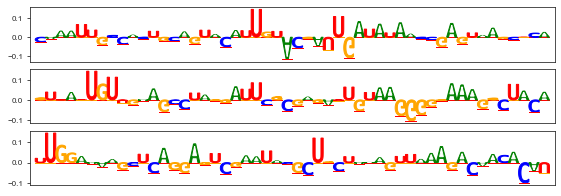

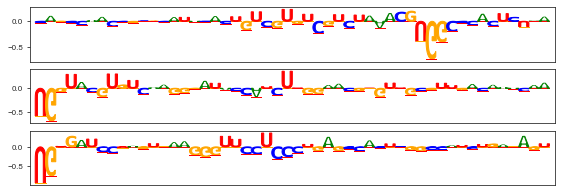

In [12]:
plot_attribution(no_aug_pred_random, mrl_model_no_aug, subset='highest_ten',samples=3)
plot_attribution(no_aug_pred_random, mrl_model_no_aug, subset='lowest_ten',samples=3)

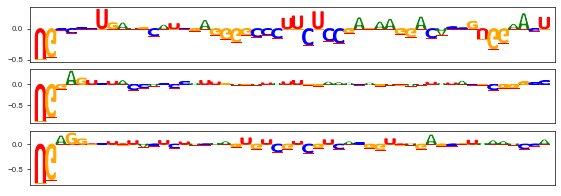

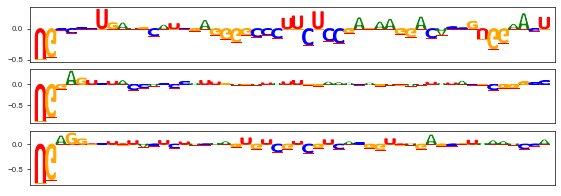

In [13]:
# generate attribution maps for three random example utrs starting with 'UG'
f=3
data = no_aug_pred_random[no_aug_pred_random['utr'].apply(lambda x: x.startswith('TG'))].sample(n=f)
samples=len(data)
data_seq = one_hot_encode(data, seq_len=50)
data_ig = ig.integrated_gradients(mrl_model_no_aug, data_seq)
sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

602


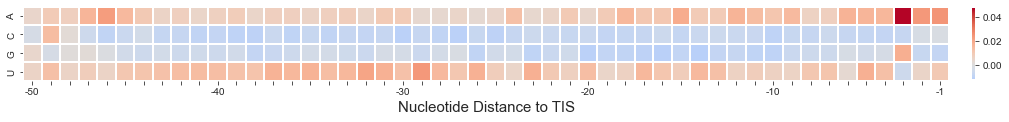

602


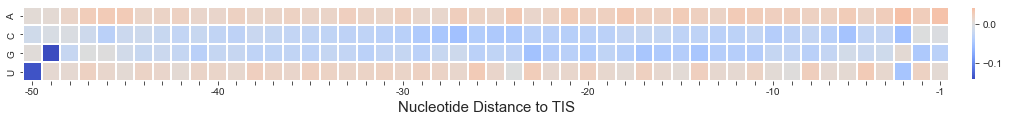

6014


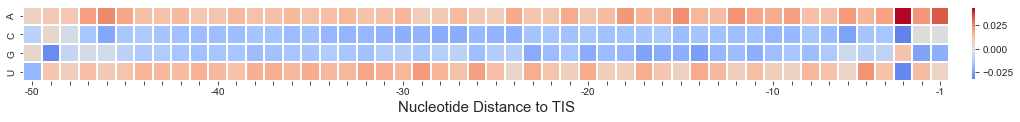

In [14]:
plot_meta(no_aug_pred_random, mrl_model_no_aug, subset = 'highest_ten')
plot_meta(no_aug_pred_random, mrl_model_no_aug, subset = 'lowest_ten')
plot_meta(no_aug_pred_random, mrl_model_no_aug)

3
3


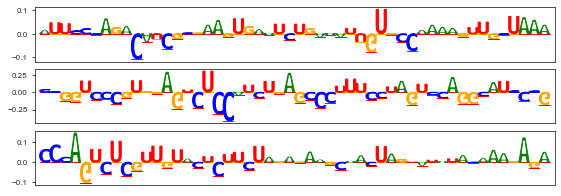

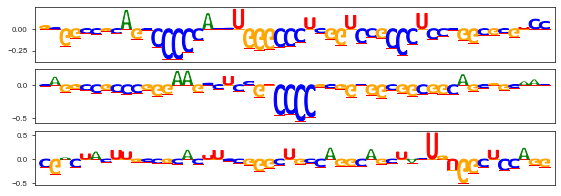

In [15]:
plot_attribution(no_aug_pred_human, hmrl_model_no_aug, subset='highest_ten',samples=3)
plot_attribution(no_aug_pred_human, hmrl_model_no_aug, subset='lowest_ten',samples=3)

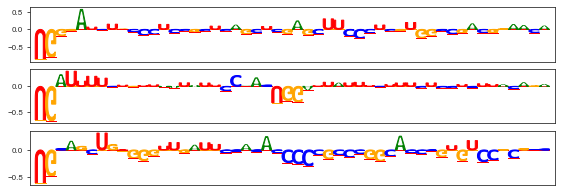

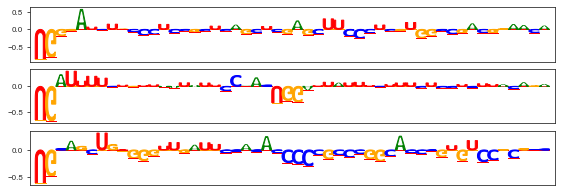

In [16]:
# generate attribution maps for three random example utrs starting with 'UG'
f=3
data = no_aug_pred_human[no_aug_pred_human['utr'].apply(lambda x: x.startswith('TG'))].sample(n=f)
samples=len(data)
data_seq = one_hot_encode(data, seq_len=50)
data_ig = ig.integrated_gradients(hmrl_model_no_aug, data_seq)
sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

395


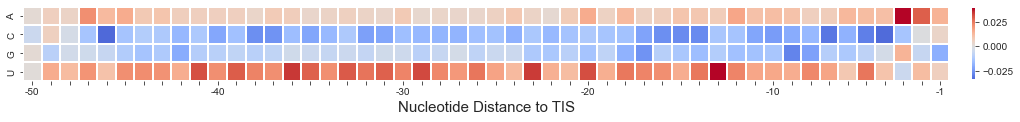

395


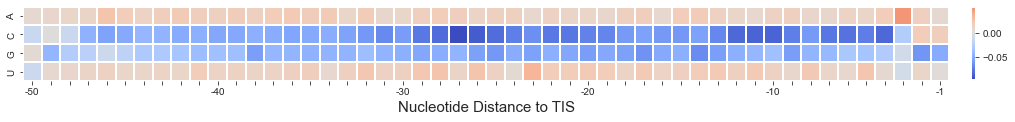

3942


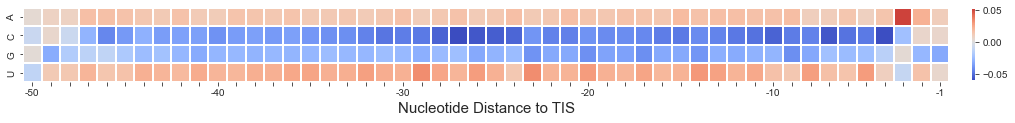

In [17]:
plot_meta(no_aug_pred_human, hmrl_model_no_aug, subset = 'highest_ten')
plot_meta(no_aug_pred_human, hmrl_model_no_aug, subset = 'lowest_ten')
plot_meta(no_aug_pred_human, hmrl_model_no_aug)

We can observe 'TG' in the start of some utrs as an artificially introduced signal from the experimental design. Therefore we perform attribution without these sequences for both conditions.

In [18]:
#import utrs with measured and predicted mean ribosome load

#synthetic utrs with mean ribosome load predicted by MRL model (trained on synthetic utrs without AUG and UG as first two nucleotides)
no_ug_pred_random=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_ug_random_test_pred.csv', index_col=[0])

#human utrs with mean ribosome load predicted by hMRL model (trained on human utrs without AUG and UG as first two nucleotides)
no_ug_pred_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_ug_human_test_pred.csv', index_col=[0])

#import the two models trained on human/synthetic utrs without AUG respectively
mrl_model_no_ug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_ug.hdf5')
hmrl_model_no_ug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_ug.hdf5')

3


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


3


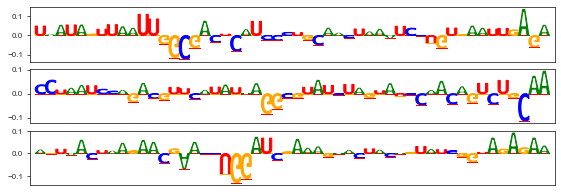

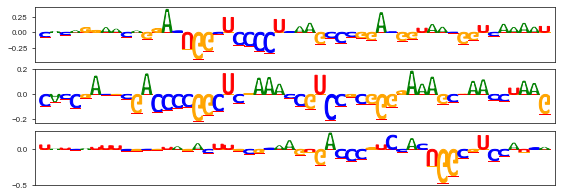

In [19]:
plot_attribution(no_ug_pred_random, mrl_model_no_ug, subset='highest_ten',samples=3)
plot_attribution(no_ug_pred_random, mrl_model_no_ug, subset='lowest_ten',samples=3)

582


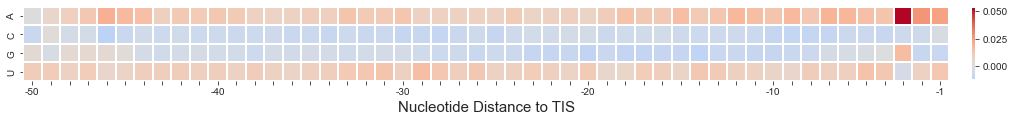

582


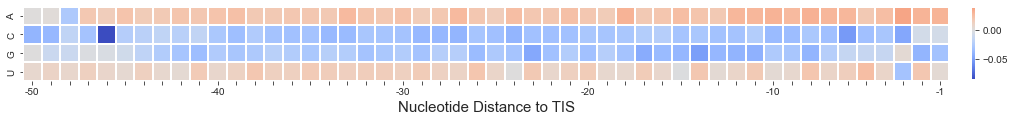

In [20]:
plot_meta(no_ug_pred_random, mrl_model_no_ug, subset = 'highest_ten')
plot_meta(no_ug_pred_random, mrl_model_no_ug, subset = 'lowest_ten')


5813


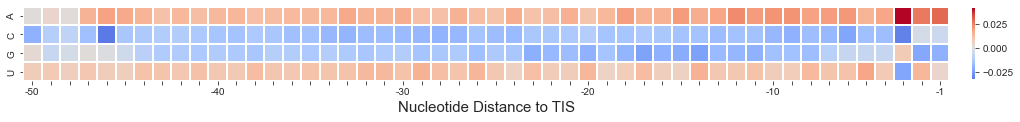

In [21]:
plot_meta(no_ug_pred_random, mrl_model_no_ug)

3
3


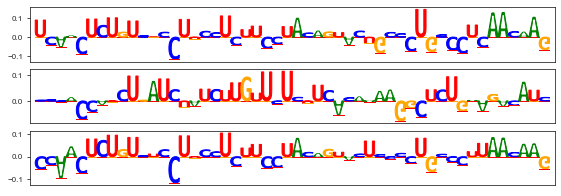

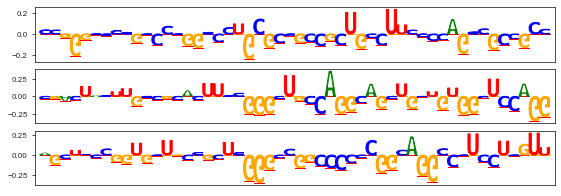

In [22]:
plot_attribution(no_ug_pred_human, hmrl_model_no_ug, subset='highest_ten',samples=3)
plot_attribution(no_ug_pred_human, hmrl_model_no_ug, subset='lowest_ten',samples=3)

386


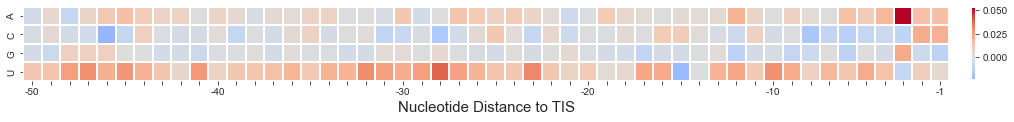

386


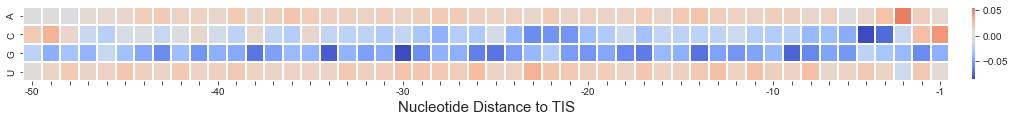

In [23]:
plot_meta(no_ug_pred_human, hmrl_model_no_ug, subset = 'highest_ten')
plot_meta(no_ug_pred_human, hmrl_model_no_ug, subset = 'lowest_ten')

3853


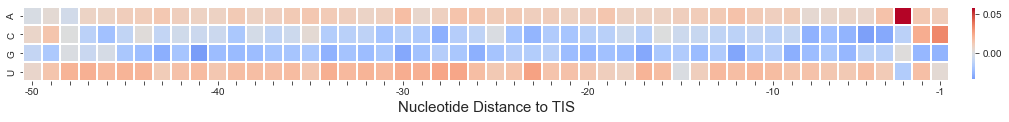

In [24]:
plot_meta(no_ug_pred_human, hmrl_model_no_ug)